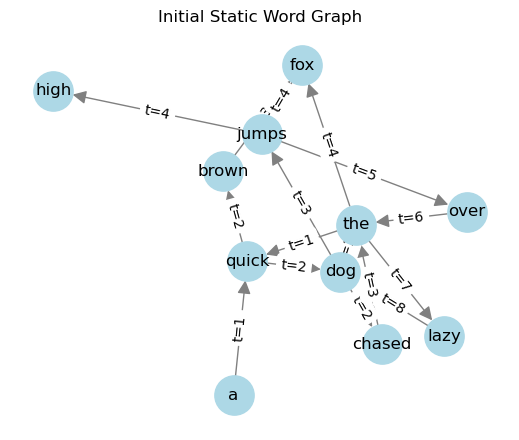

Epoch 1, Loss: 2.8704
Epoch 2, Loss: 0.0000
Epoch 3, Loss: 0.0000
Epoch 4, Loss: 0.0000
Epoch 5, Loss: 0.0000


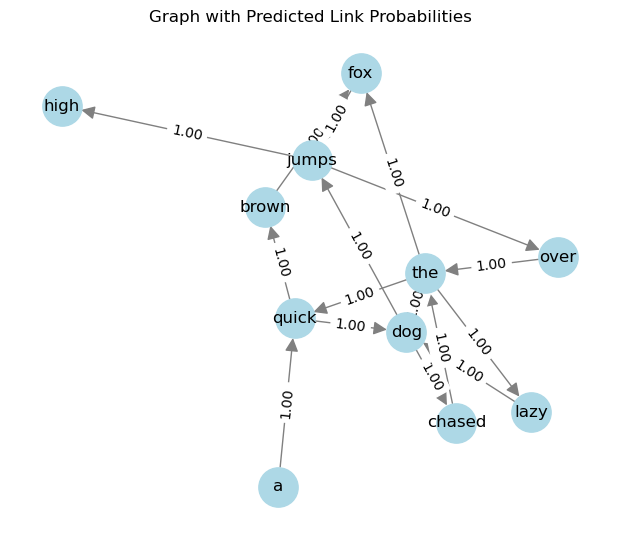

In [4]:
# Word Graph TGN Toy Notebook (Clean Version)
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import networkx as nx
from IPython.display import Image

# ========== Simulated Word Graph from Sentences ==========
sentences = [
    "the quick brown fox jumps over the lazy dog",
    "the dog chased the fox",
    "a quick dog jumps high"
]

word_list = []
for sentence in sentences:
    word_list.extend(sentence.split())
words = list(dict.fromkeys(word_list))
word_to_idx = {w: i for i, w in enumerate(words)}
idx_to_word = {i: w for w, i in word_to_idx.items()}

events = []
time = 1.0
for sentence in sentences:
    tokens = sentence.split()
    for i in range(len(tokens) - 1):
        src = word_to_idx[tokens[i]]
        dst = word_to_idx[tokens[i+1]]
        events.append((src, dst, time, 1))
        time += 1.0

n_nodes = len(words)

# ========== Graph Visualization ==========
initial_edges = [(u, v) for (u, v, t, label) in events if label == 1]
G_static = nx.DiGraph()
G_static.add_edges_from(initial_edges)
plt.figure(figsize=(5, 4))
static_pos = nx.spring_layout(G_static)
labels = {i: w for i, w in enumerate(words)}
nx.draw(G_static, static_pos, labels=labels, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800, arrowsize=20)
edge_labels_named = {(word_to_idx[tokens[i]], word_to_idx[tokens[i+1]]): f"t={i+1}" for sentence in sentences for i, tokens in [(i, sentence.split()) for i in range(len(sentence.split()) - 1)]}
nx.draw_networkx_edge_labels(G_static, static_pos, edge_labels=edge_labels_named)
plt.title("Initial Static Word Graph")
plt.show()

# ========== Graph Animation ==========
G = nx.DiGraph()
fig, ax = plt.subplots(figsize=(5, 4))
pos = static_pos  # Use static layout for consistency

def update(i):
    ax.clear()
    u, v, t, label = events[i]
    G.add_edge(u, v)
    edge_colors = ["gray" for _ in G.edges]
    nx.draw(G, pos, with_labels=True, labels=labels, node_color='lightblue', edge_color=edge_colors, node_size=800, arrowsize=20, ax=ax)
    ax.set_title(f"Graph at t={t}, Event: ({idx_to_word[u]} → {idx_to_word[v]})")

ani = animation.FuncAnimation(fig, update, frames=len(events), interval=1000, repeat=False)
ani.save("word_graph_animation.gif", writer="pillow")
plt.close(fig)
Image(filename="word_graph_animation.gif")

# ========== Text Preprocessing for Word Graph ==========
def preprocess_text_to_events(text, word_to_idx=None, start_time=1.0):
    from collections import OrderedDict
    text = text.lower().replace('', ' ')
    sentences = text.split('.')
    word_list = []
    for s in sentences:
        word_list.extend(s.strip().split())
    unique_words = list(OrderedDict.fromkeys(word_list))
    word_to_idx = word_to_idx or {w: i for i, w in enumerate(unique_words)}
    events = []
    t = start_time
    for s in sentences:
        tokens = s.strip().split()
        for i in range(len(tokens) - 1):
            if tokens[i] in word_to_idx and tokens[i+1] in word_to_idx:
                src = word_to_idx[tokens[i]]
                dst = word_to_idx[tokens[i+1]]
                events.append((src, dst, t, 1))
                t += 1.0
    return events, word_to_idx

# ========== Post-Training Graph Visualization ==========
def visualize_graph_with_predictions(model, events, labels, pos):
    G_pred = nx.DiGraph()
    edge_labels = {}
    with torch.no_grad():
        for (src, dst, t, label) in events:
            src_tensor = torch.tensor([src])
            dst_tensor = torch.tensor([dst])
            delta_t = torch.tensor([t])
            prob = model.decoder(
                model.embedding(0, torch.tensor([src, dst]), model.memory.get_memory(torch.tensor([src, dst])), torch.zeros((2, 1))),
                model.embedding(1, torch.tensor([src, dst]), model.memory.get_memory(torch.tensor([src, dst])), torch.zeros((2, 1)))
            ).item()
            G_pred.add_edge(src, dst)
            edge_labels[(src, dst)] = f"{prob:.2f}"

    plt.figure(figsize=(6, 5))
    nx.draw(G_pred, pos, with_labels=True, labels=labels, node_color='lightblue', edge_color='gray', node_size=800, arrowsize=20)
    nx.draw_networkx_edge_labels(G_pred, pos, edge_labels=edge_labels)
    plt.title("Graph with Predicted Link Probabilities")
    plt.show()

# ========== TGN Model and Training ==========

class NodeMemory(nn.Module):
    def __init__(self, n_nodes, memory_dim, message_dim):
        super().__init__()
        self.memory = nn.Parameter(torch.zeros(n_nodes, memory_dim), requires_grad=False)
        self.gru = nn.GRUCell(message_dim, memory_dim)

    def forward(self, node_ids, messages):
        current_memory = self.memory[node_ids]
        updated = self.gru(messages, current_memory)
        self.memory.data[node_ids] = updated.detach()
        return updated

    def get_memory(self, node_ids):
        return self.memory[node_ids]

    def reset(self):
        self.memory.data.zero_()

class MessageFunction(nn.Module):
    def forward(self, s_src, s_dst, delta_t):
        time_feat = delta_t.unsqueeze(1)
        return torch.cat([s_src, s_dst, time_feat], dim=1)

class MessageAggregator(nn.Module):
    def forward(self, messages):
        return messages.mean(dim=0, keepdim=True)

class TimeEncoding(nn.Module):
    def __init__(self, dimension):
        super().__init__()
        self.freqs = nn.Parameter(torch.randn(dimension), requires_grad=True)

    def forward(self, delta_t):
        return torch.cat([torch.sin(self.freqs * delta_t), torch.cos(self.freqs * delta_t)], dim=-1)

class AttentionEmbedding(nn.Module):
    def __init__(self, memory_dim, time_dim, emb_dim):
        super().__init__()
        self.time_encoder = TimeEncoding(time_dim)
        self.query_proj = nn.Linear(memory_dim + time_dim * 2, emb_dim)
        self.key_proj = nn.Linear(memory_dim + time_dim * 2, emb_dim)
        self.value_proj = nn.Linear(memory_dim + time_dim * 2, emb_dim)
        self.final = nn.Linear(emb_dim, emb_dim)

    def forward(self, node_idx, neighbors, memories, delta_ts):
        time_enc = self.time_encoder(delta_ts)
        x = torch.cat([memories, time_enc], dim=-1)
        queries = self.query_proj(x[node_idx].unsqueeze(0))
        keys = self.key_proj(x)
        values = self.value_proj(x)
        attn_scores = (queries @ keys.T) / np.sqrt(keys.shape[-1])
        attn_weights = torch.softmax(attn_scores, dim=-1)
        context = attn_weights @ values
        return self.final(context)

class LinkPredictor(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(2 * emb_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, src_emb, dst_emb):
        x = torch.cat([src_emb, dst_emb], dim=1)
        return torch.sigmoid(self.fc(x))

class TGN(nn.Module):
    def __init__(self, n_nodes, memory_dim=16, emb_dim=16, message_dim=33, time_dim=8):
        super().__init__()
        self.memory = NodeMemory(n_nodes, memory_dim, message_dim)
        self.message_fn = MessageFunction()
        self.aggregator = MessageAggregator()
        self.embedding = AttentionEmbedding(memory_dim, time_dim, emb_dim)
        self.decoder = LinkPredictor(emb_dim)

    def forward(self, src, dst, t, delta_t):
        s_src = self.memory.get_memory(src)
        s_dst = self.memory.get_memory(dst)
        msg = self.message_fn(s_src, s_dst, delta_t)
        agg_msg = self.aggregator(msg)
        self.memory(src, agg_msg)
        self.memory(dst, agg_msg)
        neighbors = torch.cat([src, dst])
        memories = self.memory.get_memory(neighbors)
        delta_ts = torch.zeros((len(neighbors), 1))
        src_emb = self.embedding(0, neighbors, memories, delta_ts)
        dst_emb = self.embedding(1, neighbors, memories, delta_ts)
        return self.decoder(src_emb, dst_emb)

# Training setup
model = TGN(n_nodes).to(torch.device("cpu"))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.BCELoss()
model.memory.reset()

# Training loop
for epoch in range(5):
    total_loss = 0
    for (src, dst, t, label) in events:
        src = torch.tensor([src])
        dst = torch.tensor([dst])
        delta_t = torch.tensor([t])
        label = torch.tensor([[label]], dtype=torch.float32)
        pred = model(src, dst, t, delta_t)
        loss = loss_fn(pred, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

# Call after training phase
visualize_graph_with_predictions(model, events, labels, pos)
